In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
!pip install chainer
!pip install imantics
!pip install simplification

In [20]:
import numpy as np
import cv2
import math
import os
import random
import cv2

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda, serializers, Variable
import sys
from os import path
from uuid import uuid4
import json
from imantics import Polygons, Mask
from simplification.cutil import simplify_coords_vwp
import pandas as pd


from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import shapely.wkt
from shapely.geometry import Polygon

import tensorflow as tf
import keras
from keras import Sequential
from keras import layers
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from PIL import Image, ImageDraw
from shapely import wkt
import matplotlib.pyplot as plt

In [22]:
xbd_labels_dir="C:\\Users\\PC\\Desktop\\damage_assessement_data\\train\\labels"
xbd_images_dir="C:\\Users\\PC\\Desktop\\damage_assessement_data\\train\\images"
localization_model_weights="C:\\Users\\PC\\Desktop\\drac_saved_files\\localization_model\\saved_model.pb"
mean_weight="C:\\Users\\PC\\Desktop\\drac_saved_files\\mean.npy"
model_output_dir="C:\\Users\\PC\\Desktop\\damage_assessement_data\\train\\model_predictions"
os.makedirs(model_output_dir, exist_ok=True)
classification_model_weights="C:\\Users\\PC\\Desktop\\drac_saved_files\\classification_model\\checkpoint"

In [23]:
import chainer
import chainer.functions as F
import chainer.links as L


class UNet(chainer.Chain):

    def __init__(self):
        super(UNet, self).__init__(
            c0=L.Convolution2D(3, 32, 3, 1, 1),
            c1=L.Convolution2D(32, 64, 4, 2, 1),
            c2=L.Convolution2D(64, 64, 3, 1, 1),
            c3=L.Convolution2D(64, 128, 4, 2, 1),
            c4=L.Convolution2D(128, 128, 3, 1, 1),
            c5=L.Convolution2D(128, 256, 4, 2, 1),
            c6=L.Convolution2D(256, 256, 3, 1, 1),
            c7=L.Convolution2D(256, 512, 4, 2, 1),
            c8=L.Convolution2D(512, 512, 3, 1, 1),

            dc8=L.Deconvolution2D(1024, 512, 4, 2, 1),
            dc7=L.Convolution2D(512, 256, 3, 1, 1),
            dc6=L.Deconvolution2D(512, 256, 4, 2, 1),
            dc5=L.Convolution2D(256, 128, 3, 1, 1),
            dc4=L.Deconvolution2D(256, 128, 4, 2, 1),
            dc3=L.Convolution2D(128, 64, 3, 1, 1),
            dc2=L.Deconvolution2D(128, 64, 4, 2, 1),
            dc1=L.Convolution2D(64, 32, 3, 1, 1),
            dc0=L.Convolution2D(64, 2, 3, 1, 1),
            bnc0=L.BatchNormalization(32),
            bnc1=L.BatchNormalization(64),
            bnc2=L.BatchNormalization(64),
            bnc3=L.BatchNormalization(128),
            bnc4=L.BatchNormalization(128),
            bnc5=L.BatchNormalization(256),
            bnc6=L.BatchNormalization(256),
            bnc7=L.BatchNormalization(512),
            bnc8=L.BatchNormalization(512),
            bnd8=L.BatchNormalization(512),
            bnd7=L.BatchNormalization(256),
            bnd6=L.BatchNormalization(256),
            bnd5=L.BatchNormalization(128),
            bnd4=L.BatchNormalization(128),
            bnd3=L.BatchNormalization(64),
            bnd2=L.BatchNormalization(64),
            bnd1=L.BatchNormalization(32)
        )


    def forward(self, x):
        x = x.astype(np.float32)
        e0 = F.relu(self.bnc0(self.c0(x)))
        e1 = F.relu(self.bnc1(self.c1(e0)))
        e2 = F.relu(self.bnc2(self.c2(e1)))
        del e1
        e3 = F.relu(self.bnc3(self.c3(e2)))
        e4 = F.relu(self.bnc4(self.c4(e3)))
        del e3
        e5 = F.relu(self.bnc5(self.c5(e4)))
        e6 = F.relu(self.bnc6(self.c6(e5)))
        del e5
        e7 = F.relu(self.bnc7(self.c7(e6)))
        e8 = F.relu(self.bnc8(self.c8(e7)))

        d8 = F.relu(self.bnd8(self.dc8(F.concat([e7, e8]))))
        del e7, e8
        d7 = F.relu(self.bnd7(self.dc7(d8)))
        del d8
        d6 = F.relu(self.bnd6(self.dc6(F.concat([e6, d7]))))
        del d7, e6
        d5 = F.relu(self.bnd5(self.dc5(d6)))
        del d6
        d4 = F.relu(self.bnd4(self.dc4(F.concat([e4, d5]))))
        del d5, e4
        d3 = F.relu(self.bnd3(self.dc3(d4)))
        del d4
        d2 = F.relu(self.bnd2(self.dc2(F.concat([e2, d3]))))
        del d3, e2
        d1 = F.relu(self.bnd1(self.dc1(d2)))
        del d2
        d0 = self.dc0(F.concat([e0, d1]))
        return d0


    def __call__(self, x, t):
        h = self.forward(x)
        loss = F.softmax_cross_entropy(h, t, ignore_label=255)
        accuracy = F.accuracy(h, t, ignore_label=255)
        chainer.report({'loss': loss, 'accuracy': accuracy}, self)
        return loss

In [24]:
class LocalizationModel:
    def __init__(self, model_path, mean):
        # Load UNet model
        self.model = UNet()
        # Load the pre-trained model weights
        serializers.load_npz(model_path, self.model)

        # Set mean
        self.mean = mean[np.newaxis, np.newaxis, :]

    def pad_and_crop_image(self, image):
        h, w, c = image.shape
        # calculate padding
        h_padded = int(math.ceil(float(h) / 16.0) * 16)
        w_padded = int(math.ceil(float(w) / 16.0) * 16)
        # add padding to image
        padding_x1, padding_y1 = (w_padded - w) // 2, (h_padded - h) // 2
        padding_x2, padding_y2 =  w_padded - w - padding_x1, h_padded - h - padding_y1
        image_padded = np.pad(image, ((padding_y1, padding_y2), (padding_x1, padding_x2), (0, 0)), 'symmetric')
        # normalize pixel values to the range [0, 1]
        image_in = (image_padded - self.mean) / 255.0
        # transpose to (batch, channel, height, width)
        image_in = image_in.transpose(2, 0, 1)
        # add batch dimension
        image_in = image_in[np.newaxis, :, :, :]
        # convert to chainer Variable
        image_in = Variable(np.asarray(image_in, dtype=np.float32))
        # crop the image
        left,right, top, bottom =  padding_x1, padding_x1 + w, padding_y1,padding_y1 + h,
        return image_in, left, right, top, bottom

    def apply_localization_to_image(self, image):
        # Pad and crop the input image
        image_in, left, right, top, bottom = self.pad_and_crop_image(image)
        #chainer.using_config('device', -1)
        # Disable training mode for Chainer
        with chainer.using_config('train', False):
            score = self.model.forward(image_in)
        # softmax to obtain the scores
        score = F.softmax(score)
        # get relevant scores
        score = score.data[0]
        # crop the score
        score = score[:, top:bottom, left:right]
        return score

In [25]:
# Generate Json file from output of applying localization
def generate_json_from_predictions(image, score, output_file):
    building_score = score[1]
    #extract the score associated with buildings from applying localization model
    building_mask_pred = (np.argmax(score, axis=0) == 1)
    # generate polygons from the binary mask
    polygons = Mask(building_mask_pred).polygons()
    new_predictions = []
    for poly in polygons:
        # consider polygons with over 3 vertices
        if len(poly) >= 3:
            f = poly.reshape(-1, 2)
            #simplifies the polygon vertices
            simplified_vw = simplify_coords_vwp(f, .3)
            if len(simplified_vw) > 2:
                    mpoly = []
                    for i in simplified_vw:
                        mpoly.append((i[0], i[1]))
                    mpoly.append((simplified_vw[0][0], simplified_vw[0][1]))
                    new_predictions.append(mpoly)
    # create blank json dictionary template
    output_json = {
        "features": {
            "xy": []
        }
    }
    # create uuid for building and insert wkt value of the detected buildings
    building_template = lambda poly, uuid: {
        'properties': {
            'uid': uuid
        },
        'wkt': poly
    }
    # add the building xy features to output json
    for polygon in new_predictions:
        wkt = 'POLYGON (('
        for coords in polygon:
            wkt += "{} {},".format(coords[0], coords[1])
        wkt = wkt[:-1] + '))'
        uuid = str(uuid4())
        poly = building_template(wkt, uuid)
        output_json['features']['xy'].append(poly)
    # save the output to json file
    with open(output_file, 'w') as out_file:
        json.dump(output_json, out_file)

In [26]:
def crop_buildings_from_image(img_path, label_path,  output_dir, output_csv):
    x_data = []
    # open image
    img_obj = Image.open(img_path)
    img_array = np.array(img_obj)
    # get label for the image
    label_file = open(label_path)
    label_data = json.load(label_file)
    # crop the images using xy wkt value
    for feat in label_data['features']['xy']:
        building_id_image = feat['properties']['uid'] + ".png"
        polygon_geom = shapely.wkt.loads(feat['wkt'])
        polygon_pts = np.array(list(polygon_geom.exterior.coords))
        height, width, channels = img_array.shape
        # calculate bounding box coordinates
        xcoords, ycoords = polygon_pts[:, 0], polygon_pts[:, 1]
        xmin, xmax = np.min(xcoords), np.max(xcoords)
        ymin, ymax = np.min(ycoords), np.max(ycoords)
        xdiff, ydiff = xmax - xmin, ymax - ymin
        # exoand bounding box by 80%
        xmin = max(int(xmin - (xdiff * 0.8)), 0)
        xmax = min(int(xmax + (xdiff * 0.8)), width)
        ymin = max(int(ymin - (ydiff * 0.8)), 0)
        ymax = min(int(ymax + (ydiff * 0.8)), height)
        # crop the building
        poly_img = img_array[ymin:ymax, xmin:xmax, :]
        # save the cropped image
        cv2.imwrite(os.path.join(output_dir,building_id_image), poly_img)
        x_data.append(building_id_image)
    # dataFrame with building IDs
    data_array = {'building_id': x_data}
    # write DataFrame to CSV file
    df = pd.DataFrame(data = data_array)
    df.to_csv(output_csv)

In [27]:
# def classification_model():
#     # input layer
#     input_layer = layers.Input(shape=(128, 128, 3))
#     # pre-trained ResNet50 as base model
#     resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
#     # freeze base model layers
#     for layer in resnet_model.layers:
#         layer.trainable = False
#     # input through ResNet model
#     base_resnet_model = resnet_model(input_layer)
#     # flatten output from the resnet model
#     base_resnet_model = layers.Flatten()(base_resnet_model)
#     # # conv2d and maxpool layers
#     x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(input_layer)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    
#     x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    
#     x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
#     # flatten output from conv2d and maxpool layers
#     x = layers.Flatten()(x)
#     # concatenate outputs of convolutional layers and base ResNet model
#     concatenated_layers = layers.Concatenate()([x, base_resnet_model])
#     # Fully connected layers
#     x = layers.Dense(1024, activation='relu')(x)
#     x = layers.Dropout(0.3)(x) 
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.4)(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.3)(x) 
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.2)(x)
#     # output layer
#     output = layers.Dense(4, activation='softmax')(x)
#     # define model
#     model = Model(inputs=input_layer, outputs=output)
#     return model
# Define Classification Model
# def classification_model():
#     # input layer
#     input_layer = layers.Input(shape=(128, 128, 3))
#     # pre-trained ResNet50 as base model
#     resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
#     # freeze base model layers
#     for layer in resnet_model.layers:
#         layer.trainable = False
#     # input through ResNet model
#     base_resnet_model = resnet_model(input_layer)
#     # flatten output from the resnet model
#     base_resnet_model = layers.Flatten()(base_resnet_model)
#     # # conv2d and maxpool layers
#     x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(input_layer)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
#     x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
#     x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
#     # flatten output from conv2d and maxpool layers
#     x = layers.Flatten()(x)
#     # concatenate outputs of convolutional layers and base ResNet model
#     concatenated_layers = layers.Concatenate()([x, base_resnet_model])
#     # Fully connected layers
#     x = layers.Dense(2024, activation='relu')(concatenated_layers)
#     x = layers.Dense(524, activation='relu')(x)
#     x = layers.Dense(124, activation='relu')(x)
#     # output layer
#     output = layers.Dense(4, activation='softmax')(x)
#     # define model
#     model = Model(inputs=input_layer, outputs=output)
#     return model


# def classification_model():
#     # Define the input layer with shape (128, 128, 3)
#     inputs = layers.Input(shape=(128, 128, 3))
    
#     # ResNet50 model pre-trained on ImageNet without the top layer
#     base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    
#     # Freeze the layers of the base model so they are not trainable
#     for layer in base_model.layers:
#         layer.trainable = False
    
#     # convolutional layer with 32 filters, 5x5 kernel size, and ReLU activation
#     x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(inputs)
#     # average pooling layer with pool size (2, 2)
#     x = layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    
#     # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
#     x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
#     # Add average pooling layer with pool size (2, 2)
#     x = layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    
#     # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
#     x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
#     # pooling layer with pool size (2, 2)
#     x = layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
    
#     # Flatten the output of the convolutional layers
#     x = layers.Flatten()(x)
    
#     # Pass the input through the base ResNet50 model and flatten its output
#     base_resnet = base_model(inputs)
#     base_resnet = layers.Flatten()(base_resnet)
    
#     # Concatenate the output of the convolutional layers and the output of the base ResNet50 model
#     concatenated_layers = layers.Concatenate()([x, base_resnet])
    
#     # fully connected layer with 2024 neurons and ReLU activation
#     x = layers.Dense(2024, activation='relu')(concatenated_layers)
#     # fully connected layer with 524 neurons and ReLU activation
#     x = layers.Dense(524, activation='relu')(x)
#     # dropout layer with dropout rate 0.4
#     x = layers.Dropout(0.4)(x)
#     # fully connected layer with 124 neurons and ReLU activation
#     x = layers.Dense(124, activation='relu')(x)
    
#     # Output layer with 4 neurons for classification and softmax activation
#     output = layers.Dense(4, activation='softmax')(x)
    
#     # model with input and output layers
#     model = Model(inputs=inputs, outputs=output)
    
#     return model

In [28]:
# Loss function for ordinal loss from https://github.com/JHart96/keras_ordinal_categorical_crossentropy
def ordinal_loss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * keras.losses.categorical_crossentropy(y_true, y_pred )

def classification_model():
    # Define the input layer with shape (128, 128, 3)
    inputs = layers.Input(shape=(128, 128, 3))

    # ResNet50 model pre-trained on ImageNet without the top layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

    # Freeze the layers of the base model so they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # convolutional layer with 32 filters, 5x5 kernel size, and ReLU activation
    x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(inputs)
    # max pooling layer with pool size (2, 2)
    x = x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    # max pooling layer with pool size (2, 2)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    # pooling layer with pool size (2, 2)
    x = x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # Flatten the output of the convolutional layers
    x = layers.Flatten()(x)

    # Pass the input through the base ResNet50 model and flatten its output
    base_resnet = base_model(inputs)
    base_resnet = layers.Flatten()(base_resnet)

    # Concatenate the output of the convolutional layers and the output of the base ResNet50 model
    concatenated_layers = layers.Concatenate()([x, base_resnet])

    # fully connected layer with 2024 neurons and ReLU activation
    x = layers.Dense(2024, activation='relu')(concatenated_layers)
    # fully connected layer with 524 neurons and ReLU activation
    x = layers.Dense(524, activation='relu')(x)
    # dropout layer with dropout rate 0.4
    x = layers.Dropout(0.4)(x)
    # fully connected layer with 124 neurons and ReLU activation
    x = layers.Dense(124, activation='relu')(x)
    # Output layer with 4 neurons for classification and softmax activation
    output = layers.Dense(4, activation='softmax')(x)

    # model with input and output layers
    model = Model(inputs=inputs, outputs=output)

    return model

In [29]:
#Decoding damage labels
damage_labels = {0: 'no-damage', 1: 'minor-damage', 2: 'major-damage', 3: 'destroyed'}

# Generate classification predictions
def classification_prediction(test_data, test_csv, model_weights, output_json_path):
    # initiate classification model
    model = classification_model()
    # load pre-trained model weights
    model.load_weights(model_weights)
    # adam optimizer
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    # compile model
    model.compile(loss=ordinal_loss, optimizer=adam, metrics=['accuracy'])
    #test dataset
    test_df = pd.read_csv(test_csv)
    gen = ImageDataGenerator(rescale=1.4)
    if test_df is not None and test_data is not None and output_json_path is not None:
        # create data from test dataframe and datapath
        test_gen = gen.flow_from_dataframe(dataframe=test_df, directory=test_data, x_col='building_id', batch_size=64, shuffle=False, seed=123, class_mode=None, target_size=(128, 128))
    else:
        # create blank json file
        blank = {}
        with open(output_json_path, 'w') as outfile:
            json.dump(blank, outfile)
        exit(0)
    test_gen.reset()
    # Get the number of buildings
    num_buildings = test_df["building_id"].count()
    # make predictions
    predictions = model.predict(test_gen,verbose=1)
    predicted_indices = np.argmax(predictions, axis=1)
    predictions_json = dict()
    # write predictions to dictionary
    for i in range(num_buildings):
        filename_raw = test_gen.filenames[i]
        filename = filename_raw.split(".")[0]
        predictions_json[filename] = damage_labels[predicted_indices[i]]
    # write predictions dictionary to json file and save it
    with open(output_json_path , 'w') as outfile:
        json.dump(predictions_json, outfile)

In [30]:
import json

def create_predicted_json(polygons_pred, classification_pred, output_file):
    # blank json
    output_json = {
        "features": {
            "xy": []
        }
    }
    # open post disaster json
    with open(classification_pred) as labels:
        label_json = json.load(labels)

        # open pre disaster json
        with open(polygons_pred) as polys:
            poly_json = json.load(polys)
            for feature in poly_json['features']['xy']:
                feature['properties']['subtype'] = label_json[feature['properties']['uid']]
                output_json['features']['xy'].append(feature)

    # save predicted json file
    with open(output_file, 'w') as out:
        json.dump(output_json, out)

In [31]:
# Create output image using post disaster image and predicted json
def create_output_image(path_to_label,path_to_image,output_image):
    path_to_label=os.path.join(path_to_label)
    path_to_image=os.path.join(path_to_image)
    with open(path_to_label, 'rb') as image_json_file:
        image_json = json.load(image_json_file)
    # get coordinates from json label
    coords = image_json['features']['xy']
    wkt_polygons = []

    for coord in coords:
        # get damage level
        if 'subtype' in coord['properties']:
            damage = coord['properties']['subtype']
        else:
            damage = 'no-damage'
        wkt_polygons.append((damage, coord['wkt']))
    polygons = []

    for damage, poly_wkt in wkt_polygons:
        polygons.append((damage, wkt.loads(poly_wkt)))
    img = Image.open(path_to_image)
    # create drwaing polygons on images
    draw_polygons = ImageDraw.Draw(img, 'RGBA')

    # colors for damage levels
    damage_colors = {
        # No Damage - green color
        "no-damage": '#00FF00',
        # Minor Damage - blue color
        "minor-damage": '#0000FF',
        # Major Damage - orange color
        "major-damage": '#005AFF',
        # Destroyed - red color
        "destroyed": '#FF0000',
        # Unclassified - white color
        "un-classified": '#FFFFFF'
    }

    for damage, polygon in polygons:
        # get exterior coordinates of the polygon
        exterior_x,exterior_y = polygon.exterior.coords.xy
        coords = list(zip(exterior_x,exterior_y))
        # draw polygons with corresponding damage color
        draw_polygons.polygon(coords, damage_colors[damage])
    del draw_polygons

    # save the image with polygons drawn on it
    img.save(output_image, format="PNG")

In [32]:
# List files in the directory
# files = os.listdir(xbd_images_dir)
# random_choice = random.choice(range(len(files)))

# if "_pre" in files[random_choice]:
#     pre_disaster_image = files[random_choice]
#     post_disaster_image = pre_disaster_image.replace("_pre", "_post")
# elif "_post" in files[random_choice]:
#     post_disaster_image = files[random_choice]
# pre_disaster_image = post_disaster_image.replace("_post", "_pre")
pre_disaster_image="santa-rosa-wildfire_00000049_pre_disaster.png"
post_disaster_image="santa-rosa-wildfire_00000049_post_disaster.png"
# Print the selected images
print("Random Pre-Disaster Image:", pre_disaster_image)
print("Random Post-Disaster Image:", post_disaster_image)

Random Pre-Disaster Image: santa-rosa-wildfire_00000049_pre_disaster.png
Random Post-Disaster Image: santa-rosa-wildfire_00000049_post_disaster.png


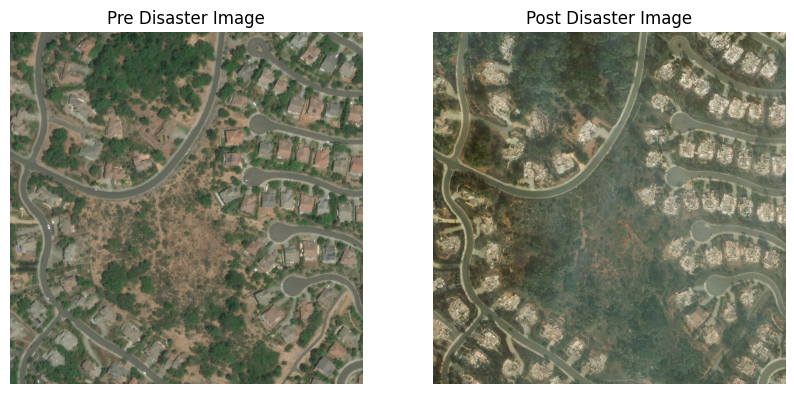

In [33]:
pre_img=Image.open(os.path.join(xbd_images_dir, pre_disaster_image))
post_img=Image.open(os.path.join(xbd_images_dir, post_disaster_image))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot images
axes[0].imshow(pre_img)
axes[0].set_title('Pre Disaster Image')

axes[1].imshow(post_img)
axes[1].set_title('Post Disaster Image')

# Hide axes
for ax in axes:
    ax.axis('off')

# Display the plot
plt.show()

In [37]:
#Run Localization
from tensorflow.keras.models import load_model
#input image_path
localization_input_image=os.path.join(xbd_images_dir, pre_disaster_image)
#output_json file
pre_disaster_predicted_json=os.path.join(model_output_dir, pre_disaster_image.replace(".png", ".json"))
# load mean
mean = np.load(mean_weight)
# initialize localization model with weights and mean
#model = LocalizationModel()
#model = load_model(localization_model_weights)
#model = tf.saved_model.load(localization_model_weights)
model = LocalizationModel(localization_model_weights, mean)
# load image as array
image = np.array(Image.open(localization_input_image))
# run localization model on the image array
score = model.apply_localization_to_image(image)
# generate json file with polygon scores
generate_json_from_predictions(image, score, pre_disaster_predicted_json)

UnpicklingError: Failed to interpret file 'C:\\Users\\PC\\Desktop\\drac_saved_files\\localization_model\\saved_model.pb' as a pickle

In [ ]:
#Extract polygons from post image
input_image=os.path.join(xbd_images_dir, post_disaster_image)
label_path=os.path.join(model_output_dir, pre_disaster_image.replace(".png", ".json"))
#Path to new directory to save images
polygon_image_dir=os.path.join(model_output_dir,"polygon_images")
os.makedirs(polygon_image_dir, exist_ok=True)
#Path to save the csv file
post_disaster_csv=os.path.join(model_output_dir, post_disaster_image.replace(".png", ".csv"))
#crop buildings from post-image
crop_buildings_from_image(input_image, label_path, polygon_image_dir, post_disaster_csv)

In [ ]:
#Run classification model
post_disaster_classification_json=os.path.join(model_output_dir, post_disaster_image.replace(".png", ".json"))
classification_prediction(polygon_image_dir, post_disaster_csv, classification_model_weights, post_disaster_classification_json)

In [ ]:
#path to predicted json file
post_disaster_predicted_json = post_disaster_image.replace("_post_disaster", "_predicted")
post_disaster_predicted_json = post_disaster_predicted_json.replace(".png", ".json")
print(post_disaster_predicted_json)
post_disaster_predicted_json_path=os.path.join(model_output_dir, post_disaster_predicted_json)
# combine the json based on the building id
create_predicted_json(pre_disaster_predicted_json, post_disaster_classification_json, post_disaster_predicted_json_path)

In [ ]:
#Final Output image
post_disaster_predicted_image=post_disaster_predicted_json_path.replace(".json", ".png")
post_disaster_image_path=os.path.join(xbd_images_dir, post_disaster_image)
#draw damage levels on post-image
create_output_image(post_disaster_predicted_json_path, post_disaster_image_path,post_disaster_predicted_image)

In [ ]:
# plot comparision between ground truth and predicted file
post_image = Image.open(os.path.join(xbd_images_dir, post_disaster_image))
predicted_image=cv2.imread(post_disaster_predicted_image)

#Ground truth image
ground_truth_label=os.path.join(xbd_labels_dir, post_disaster_image.replace(".png", ".json"))
ground_truth_image = post_disaster_predicted_image.replace("_predicted", "_ground_truth")

create_output_image(ground_truth_label, post_disaster_image_path,ground_truth_image)
ground_truth_image = cv2.imread(ground_truth_image)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot images
axes[0].imshow(post_image)
axes[0].set_title('Post Disaster Image')

axes[1].imshow(predicted_image)
axes[1].set_title('Predicted Image')

axes[2].imshow(ground_truth_image)
axes[2].set_title('Ground Truth Image')

# Hide axes
for ax in axes:
    ax.axis('off')

# Display the plot
plt.show()

In [ ]:
# # Cleanup
# !rm -rf /content/drive/MyDrive/XBD/valid/model_predictions/*